<a href="https://colab.research.google.com/github/olvad/DeepLearning_course/blob/main/RECSYS_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер.

In [ ]:
import gdown
url = 'https://raw.githubusercontent.com/hse-ds/iad-applied-ds/2024/homeworks/hw4_recsys/tracks_info.csv'
output = 'tracks_info.csv'
gdown.download(url=url, output=output, quiet=True)

'tracks_info.csv'

In [ ]:
url = 'https://raw.githubusercontent.com/hse-ds/iad-applied-ds/2024/homeworks/hw4_recsys/music_dataset.csv'
output = 'music_dataset.csv'
gdown.download(url=url, output=output, quiet=True)

'music_dataset.csv'

In [ ]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [ ]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [ ]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (1 балл).** Реализуйте метрику $MAP@k$.

In [ ]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    ap_k = 0
    count = 0

    for relevant_items, predicted_items in zip(relevant, predicted):
        if not relevant_items:
            continue
        count += 1
        trues_arr = np.isin(predicted_items[:k], relevant_items)
        placesindxs = np.cumsum(trues_arr)
        precisionK = placesindxs[trues_arr] / (np.arange(k) + 1)[trues_arr]
        score = np.sum(precisionK)
        ap_k += score / min(k, len(relevant_items))

    return ap_k / count

In [ ]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [ ]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [ ]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [ ]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [ ]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [ ]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [ ]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [ ]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [ ]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

In [ ]:
len(test_relevant)

235

In [ ]:
len(test_users)

235

**Задание 2 (1 балл).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [ ]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.

    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []

        for id in range(self.n_users):
            recommendations = self.recommend(id)
            test_preds.append(recommendations)


        test_preds = self.remove_train_items(test_preds, k)


        return test_preds[test_users]

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (1 балл).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (1 балл).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [ ]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
  chisl = np.dot(ratings, user_vector)

  zna1 = np.sqrt(np.sum(user_vector * user_vector))
  zna2 = np.sqrt(np.sum(ratings * ratings, axis=1))
  return (chisl / (zna1 * zna2))

def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    intersection = np.sum(np.logical_and(ratings > 0, user_vector > 0), axis=1)
    union = np.sum(np.logical_or(ratings > 0, user_vector > 0), axis=1)
    return intersection / union

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [ ]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int):
        user = self.R[uid]
        corrs = self.similarity(user)
        neighbors_mask = (corrs > self.alpha) & (np.arange(self.n_users) != uid)
        neighbors_ratings = self.R[neighbors_mask]
        neighbors_similarities = corrs[neighbors_mask]
        weighted_sums = np.dot(neighbors_similarities, neighbors_ratings)
        sum_of_weights = np.sum(np.abs(neighbors_similarities))
        ratings_predictions = weighted_sums / sum_of_weights if sum_of_weights != 0 else np.zeros(self.n_items)
        recommendations = np.argsort(ratings_predictions)[::-1]
        return recommendations


In [ ]:
model = User2User(train_ratings, similarity_func=pearson)
model.get_test_recommendations(15)

array([[ 9693,  7533,  6376, ...,  3106,  1666,   780],
       [24500,  2814, 33436, ..., 54220, 11950,  1019],
       [ 1073,  1019, 11493, ...,  3106,  7780,  6448],
       ...,
       [ 1019,   805,  9694, ..., 11493, 49577,  6773],
       [  805,  7533,  4032, ...,  5653,  6376,  3106],
       [18070, 33436,  2814, ..., 22325, 50211, 24290]])

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

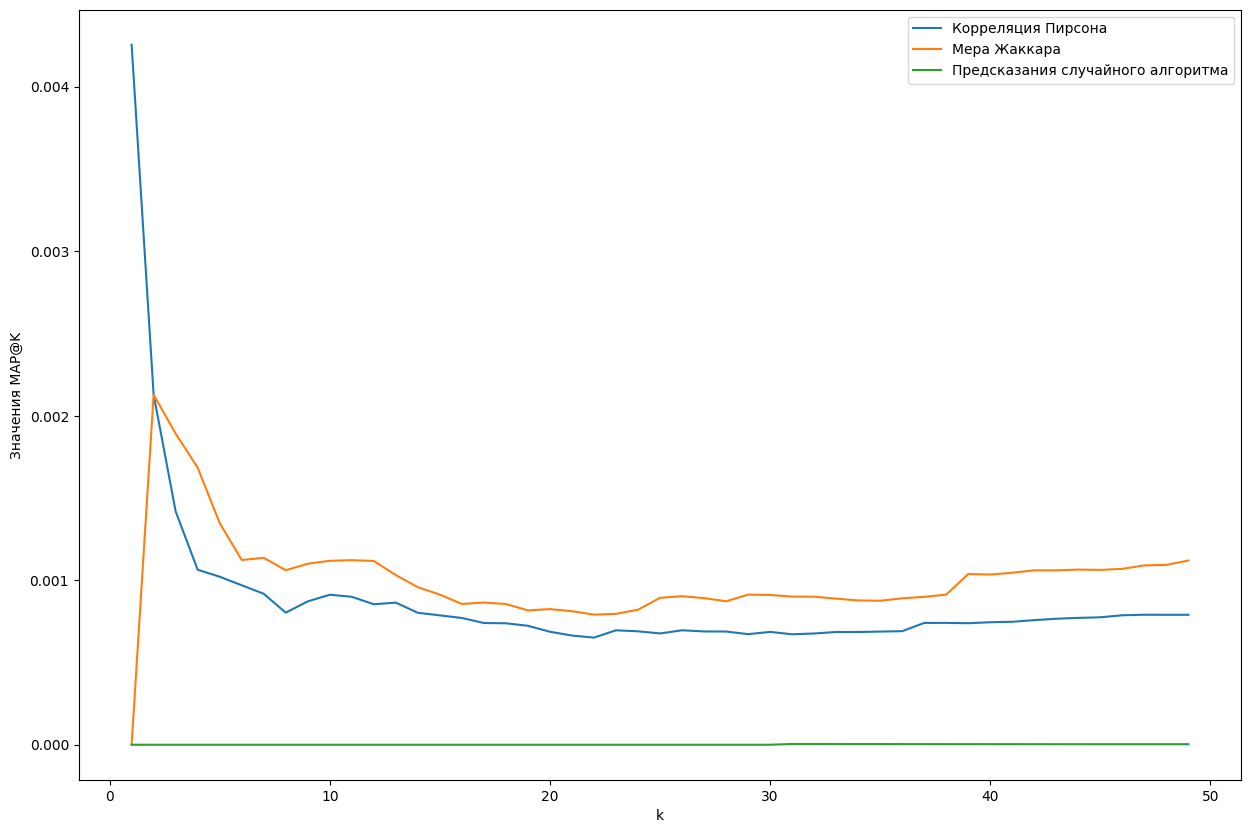

In [ ]:
kv = range(1, 50)

pears = User2User(train_ratings, similarity_func=pearson)
jacc = User2User(train_ratings, similarity_func=jaccard)

recs_pears = pears.get_test_recommendations(50)
recs_jacc = jacc.get_test_recommendations(50)
recs_random = np.array([tracks_info.sample(50)['id'].values for _ in range(model.n_users)])

plt.figure(figsize=(15, 10))

metrics_pears = [mapk(test_relevant, recs_pears, k) for k in kv]
metrics_jacc = [mapk(test_relevant, recs_jacc, k) for k in kv]
metrics_random = [mapk(test_relevant, recs_random, k) for k in kv]

plt.plot(kv, metrics_pears, label='Корреляция Пирсона')
plt.plot(kv, metrics_jacc, label='Мера Жаккара')
plt.plot(kv, metrics_random, label='Предсказания случайного алгоритма')
plt.xlabel('k')
plt.ylabel('Значения MAP@K')
plt.legend()
plt.show()

При очень маленьком K Корреляция Пирсона отлично справляется. А дальше ведет уже Мера Жаккара, которая показывает неплохие результаты (по сравнению с другими), особенно при K < 15. Потом алгоритм работает похуже

**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [ ]:
from scipy.sparse import csr_matrix,  vstack

def pearson_sparsed(ratings: csr_matrix, user_vector: csr_matrix) -> np.array:
  chisl = ratings @ user_vector.T
  zna1 = np.sqrt((user_vector.power(2)).sum())
  zna2 = np.sqrt(ratings.power(2).sum(axis=1))
  return (chisl / (zna1 * zna2)).toarray().reshape(-1)

def jaccard_sparsed(ratings: csr_matrix, user_vector: csr_matrix) -> np.array:
  user_vectorM = vstack([user_vector for _ in range(ratings.shape[0])])
  intersection = (ratings.multiply(user_vectorM)).sum(axis=1)
  union = ((ratings + user_vectorM) > 0).sum(axis=1)
  return np.array(intersection / union).reshape(-1)


In [ ]:
ratings = np.array([
    [1, 0, 1, 0, 0],
    [1, 1, 1, 1, 1],
    [0, 1, 0, 1, 1],
    [0, 0, 0, 1, 1],
    [1, 0, 1, 0, 0],
    [1, 0, 0, 1, 0]
])

user_vector = np.array([1, 0, 1, 0, 0])


c_ratings = csr_matrix(ratings)
c_user_vector = csr_matrix(user_vector)

In [ ]:
pearson(ratings,user_vector)

array([1.        , 0.63245553, 0.        , 0.        , 1.        ,
       0.5       ])

In [ ]:
pearson_sparsed(c_ratings, c_user_vector)

array([1.        , 0.63245553, 0.        , 0.        , 1.        ,
       0.5       ])

---

In [ ]:
jaccard(ratings,user_vector)

array([1.        , 0.4       , 0.        , 0.        , 1.        ,
       0.33333333])

In [ ]:
jaccard_sparsed(c_ratings, c_user_vector)

array([1.        , 0.4       , 0.        , 0.        , 1.        ,
       0.33333333])

In [ ]:
class User2UserCSR(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson_sparsed, jaccard_sparsed]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: csr_matrix):
        """
        user_vector: [n_items]
        """

        return self.similarity_func(csr_matrix(self.R), user_vector)

    def recommend(self, uid: int):
        user = self.R[uid]
        corrs = self.similarity(csr_matrix(user))
        neighbors_mask = (corrs > self.alpha) & (np.arange(self.n_users) != uid)
        neighbors_ratings = self.R[neighbors_mask]
        neighbors_similarities = corrs[neighbors_mask]
        weighted_sums = np.dot(neighbors_similarities, neighbors_ratings)
        sum_of_weights = np.sum(np.abs(neighbors_similarities))
        ratings_predictions = weighted_sums / sum_of_weights if sum_of_weights != 0 else np.zeros(self.n_items)
        recommendations = np.argsort(ratings_predictions)[::-1]
        return recommendations

In [ ]:
import time

start = time.time()


model = User2UserCSR(train_ratings, similarity_func=pearson_sparsed)
recs = model.get_test_recommendations(15)

end = time.time()

print(end - start)

57.14125680923462


In [ ]:
start = time.time()


model = User2User(train_ratings, similarity_func=pearson)
recs = model.get_test_recommendations(15)

end = time.time()

print(end - start)

27.161364316940308


Скорость стала похуже. Возможно данные недостаточно разреженны.

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [ ]:
user_id = np.random.randint(0, model.n_users)

In [ ]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
11,Long Tall Sally,['Little Richard']
27,La Camisa Negra,['Juanes']
29,Hello,['Lionel Richie']
30,"Say You, Say Me",['Lionel Richie']
46,Stop,"['Sam Brown', 'Pete Brown']"
209,I Got You (I Feel Good),['James Brown']
228,Big Big World,['Emilia']
234,Wind Of Change,['Scorpions']
257,The Lady In Red,['Chris De Burgh']
258,What A Wonderful World,['Louis Armstrong']


In [ ]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
9438,Что такое осень,['ДДТ']
17103,Просвистела,['ДДТ']
23944,Трасса Е-95,['Алиса']
11702,А что нам надо,['СерьГа']
5872,Я свободен,['Кипелов']
805,Zombie,['The Cranberries']
846,Send Me An Angel,['Scorpions']
1019,It's My Life,['Bon Jovi']
9433,В последнюю осень,['ДДТ']
1056,Don't Speak,['No Doubt']


In [ ]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
66212,Summer Love Story,"['A-Mase', 'ladynsax']"
66218,Sunny,"['Max Oazo', 'Camishe', 'The Distance', 'Igi']"
66247,Bad Habits,['Ed Sheeran']
66271,Big Love,"['DJ Mephisto', 'Festum Music', 'Havana', 'Yaa..."
66292,Love Tonight feat. Sakso,"['Antwerp House Squad', 'Sakso']"
66299,In Da Getto,"['J. Balvin', 'Skrillex']"
66337,Asereje,"['Dj Quba', 'Sandra K', 'NVSV']"
66403,Rampampam,"['Minelli', 'Mentol', 'DJ Mark']"
66404,Rampampam,"['Minelli', 'Ferki']"
66412,Dream a Little Dream,"['Louis Armstrong', 'Ella Fitzgerald']"


Впрочем порой неплохо, но хотелось бы получше

### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно.

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**LFM:**


SGD

Частная производная $e_{ui} = {r}_{ui} - \hat r_{ui} $ по $p_{u}$ равна
$- 2 ⋅ e_{ui} ⋅ q_{i} $. \\
Плюс учитываем Регуляризацию. Аналогично по по $q_{i}$. Получаем следующее

$$
\begin{equation}
\left\{
\begin{aligned}
  p_{u} ← p_{u} + \eta \left(2 ⋅ e_{ui} ⋅ q_{i} - 2 ⋅\lambda ⋅ p_{u} \right)\\q_{i} ← q_{i} + \eta \left(2 ⋅ e_{ui} ⋅ p_{u} - 2 ⋅\lambda ⋅ q_{i} \right)
  \end{aligned}
\right.
\end{equation}
$$
Где $$e_{ui} = {r}_{ui} - \hat r_{ui} $$  

**ALS:**

Матрицы P и Q  

Фиксируем одну матрицу (в первом например Q и обновляем P) и обновляем другую. Чередуем, пока не достигнем сходимости.  

$$  
\begin{equation}
\left\{
\begin{aligned}
p_{u} = (Q_{u} ^ T ⋅ Q_{u} + \lambda ⋅ I )^{-1} ⋅ Q_{u}^T ⋅ R_{u}\\q_{i} = (P_{i} ^ T ⋅ P_{i} + \lambda ⋅ I )^{-1} ⋅ P_{i}^T ⋅ R_{i}
\end{aligned}
\right.
\end{equation}
$$

$I$ —  матрица из нулей с единицами на диагонали размером $d x d$


**Задание 8 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [ ]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd'):
        super().__init__(ratings)
        self.dim = dim

        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))

        self.lr = 0.0003
        self.lamb = 0.01
        self.loss = 0 # на будущее

    def fit(self, num_iters=5):
        for epoch in tqdm(range(num_iters)):
            if self.mode == 'sgd':
              u = np.random.randint(0, self.n_users)
              i = np.random.randint(0, self.n_items)
              p = self.P[u, :]
              q = self.Q[i, : ]
              pred = np.dot(p, q)
              true = self.R[u, i]
              e_ui = true - pred
              self.P[u, :] = self.P[u, :] +  self.lr * (2 * e_ui * q - 2 * self.lamb * p)
              self.Q[i, : ] =  self.Q[i, : ]  + self.lr * (2 * e_ui * p - 2 * self.lamb * q)
              pred = self.P @ self.Q.T
              error = self.R - pred
              regularization = self.lamb * (np.linalg.norm(self.P) ** 2 + np.linalg.norm(self.Q) ** 2)
              self.loss = np.sum(error ** 2) + regularization
              print(self.loss)

            elif self.mode == 'als':
              self.P = self.R @ self.Q @ np.linalg.inv((self.Q.T @ self.Q) + self.lamb * np.eye(self.dim))
              self.Q = self.R.T @ self.P @ np.linalg.inv((self.P.T @ self.P) + self.lamb * np.eye(self.dim))
              pred = self.P @ self.Q.T
              error = self.R - pred
              regularization = self.lamb * (np.linalg.norm(self.P) ** 2 + np.linalg.norm(self.Q) ** 2)
              self.loss = np.sum(error ** 2) + regularization
              print(self.loss)



    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

In [ ]:
model_sgd = HiddenVars(train_ratings, mode='sgd')
model_sgd.fit()
# видим что лосс падает

  0%|          | 0/5 [00:00<?, ?it/s]

2060034418.5953038
2060032081.2192664
2059998185.0885794
2059992883.9845014
2059967814.0365753


In [ ]:
model_als = HiddenVars(train_ratings, mode='als')
model_als.fit()
# видим что лосс падает

  0%|          | 0/5 [00:00<?, ?it/s]

128829.18797530106
24305.899365793994
21684.992389648316
20812.754566487245
20430.30929875151


In [ ]:
preds = model_als.get_test_recommendations(15)
user_id = np.random.randint(0, model_als.n_users)
print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
37635,Обійми,['Океан Ельзи']
21541,Город,['Аквариум']
25801,Ветер знает...,['Браво']
37861,Я так соскучился,['Порнофильмы']
32638,Под небом голубым есть город золотой,['Борис Гребенщиков']
30413,Стаканы,['Аквариум']
20337,Компромисс,['Би-2']
20094,Come And Get Your Love,['Redbone']
9204,Summer Wine,"['Nancy Sinatra', 'Lee Hazlewood']"
1077,Something In The Way,['Nirvana']


In [ ]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
164,My Favourite Game,['The Cardigans']
710,The Nobodies,['Marilyn Manson']
757,Take A Look Around,['Limp Bizkit']
780,Heart-Shaped Box,['Nirvana']
934,Mein Herz Brennt,['Rammstein']
1019,It's My Life,['Bon Jovi']
1074,Lithium,['Nirvana']
1125,The Man Who Sold The World,['Nirvana']
2024,Шелкопряд,['Flёur']
2110,Москва,['Монгол Шуудан']


**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

  0%|          | 0/5 [00:00<?, ?it/s]

1052132969.9018337
1052129614.2567612
1052129362.9697508
1052123137.1406479
1052117282.6257737


  0%|          | 0/5 [00:00<?, ?it/s]

2084814373.6151118
2084790438.304199
2084763771.4026415
2084756326.227674
2084751280.128573


  0%|          | 0/5 [00:00<?, ?it/s]

4202052970.1007657
4202002137.4747634
4201984319.434168
4201949784.069628
4201934171.155232


  0%|          | 0/5 [00:00<?, ?it/s]

8348102589.112745
8348096588.354316
8348058444.959444
8348057188.823279
8348014205.080175


  0%|          | 0/10 [00:00<?, ?it/s]

1039144114.219414
1039143913.4335681
1039143445.2712774
1039139741.4653672
1039139186.225291
1039134772.7422526
1039108374.1573129
1039082199.2480611
1039067550.931401
1039049657.5799235


  0%|          | 0/10 [00:00<?, ?it/s]

2084198492.4023216
2084185344.0428312
2084163426.0985968
2084160770.8233547
2084156757.5292609
2084155271.2505624
2084142133.180526
2084135958.1690316
2084133349.9192698
2084115123.9393282


  0%|          | 0/10 [00:00<?, ?it/s]

4168197684.294311
4168155504.841281
4168148958.821193
4168139663.3600845
4168111409.455035
4168029545.6318502
4168023414.2585645
4167990761.251967
4167958315.0616107
4167846820.596642


  0%|          | 0/10 [00:00<?, ?it/s]

8320430524.892648
8320397783.651056
8320379419.140728
8320320793.505675
8320317830.873508
8320307984.517868
8320216191.01093
8320140914.295012
8319985110.462196
8319940423.982082


  0%|          | 0/15 [00:00<?, ?it/s]

1046955915.7678053
1046936187.5628934
1046935937.0775236
1046905525.6532533
1046904074.1247681
1046890842.0320294
1046888255.0414985
1046872594.7421813
1046864238.67299
1046862363.7060078
1046856608.7618765
1046833849.7731074
1046829773.362823
1046828838.8670452
1046825068.5422066


  0%|          | 0/15 [00:00<?, ?it/s]

2050478565.2167525
2050452318.6309624
2050412909.623012
2050412591.4196486
2050407495.7962942
2050405317.6814225
2050378317.8263438
2050375956.8894563
2050375798.2721772
2050375558.9541202
2050375129.9605002
2050374721.9761121
2050374413.9275608
2050339577.6844602
2050297019.239957


  0%|          | 0/15 [00:00<?, ?it/s]

4121410831.1292624
4121358255.5052567
4121342563.373129
4121283705.910145
4121259399.5331216
4121255026.997303
4121254693.954322
4121242421.855418
4121205923.268263
4121204144.2089143
4121185059.6197104
4121129191.7931957
4121124634.055351
4121121781.1211805
4121121397.4735837


  0%|          | 0/15 [00:00<?, ?it/s]

8308793734.376723
8308773297.669149
8308772762.106525
8308740502.525501
8308726351.545887
8308726539.287357
8308680714.452321
8308665745.92571
8308616927.485674
8308608113.961205
8308572988.037433
8308560095.868178
8308554731.1465225
8308508931.37005
8308493315.997875


  0%|          | 0/20 [00:00<?, ?it/s]

1019434756.9304465
1019430712.1634321
1019427685.2630996
1019423957.4692112
1019423770.5852693
1019419483.5930225
1019419400.9253539
1019419314.301928
1019404353.9400512
1019403326.9549791
1019401093.768972
1019397033.5460589
1019396859.8891433
1019386706.8904383
1019360370.0538365
1019360296.9841388
1019353919.1770211
1019349787.8296341
1019348976.8335874
1019348877.054312


  0%|          | 0/20 [00:00<?, ?it/s]

2056228514.4484358
2056228133.182152
2056219032.6915169
2056218867.297051
2056218720.4921427
2056216264.155042
2056213888.742888
2056209913.8842695
2056208260.5599482
2056203718.0589824
2056149500.9217615
2056143806.359109
2056104182.390879
2056103353.657488
2056102207.6156058
2056101430.422896
2056091983.2987692
2056081722.4340913
2056081154.756911
2056080380.789539


  0%|          | 0/20 [00:00<?, ?it/s]

4165831437.0278087
4165817520.0571895
4165809790.116691
4165805918.8158765
4165779578.500477
4165776367.5711193
4165743113.1446743
4165721928.084249
4165522548.3447833
4165503321.816491
4165502297.408424
4165480445.5601482
4165480223.460852
4165456653.149899
4165307017.9229674
4165306795.235967
4165285170.3329926
4165249104.2013564
4165245136.8746495
4165204335.583063


  0%|          | 0/20 [00:00<?, ?it/s]

8331843451.792091
8331830146.519768
8331829069.302292
8331829145.801701
8331828141.20832
8331826857.626984
8331820485.270023
8331819943.271449
8331765544.421057
8331764081.863805
8331761858.7573185
8331680736.227955
8331633097.369651
8331628460.351992
8331608781.326992
8331555434.7045
8331555148.814593
8331542966.591954
8331440590.350339
8331436702.940314


  0%|          | 0/30 [00:00<?, ?it/s]

1040436743.8285186
1040433276.3765213
1040432294.5888574
1040430132.1602595
1040412163.4475147
1040396416.0574673
1040385583.8206893
1040384077.3924892
1040378250.7446735
1040377805.7917113
1040376034.7230916
1040373318.0421717
1040361383.933014
1040360920.6278819
1040352944.9043915
1040351915.8819677
1040337019.1595501
1040325172.281216
1040304868.0646888
1040300692.8412236
1040285932.8314693
1040283392.2640313
1040282761.549202
1040282701.1078469
1040281955.268579
1040280048.8878729
1040276730.8997211
1040276516.4299476
1040276453.1252321
1040274478.0876826


  0%|          | 0/30 [00:00<?, ?it/s]

2090634917.131939
2090633527.315031
2090630627.1628997
2090629633.5896275
2090628768.4275963
2090616783.2776957
2090616533.5793538
2090597788.4767077
2090587147.4783335
2090584041.683144
2090577941.7440562
2090566370.1342933
2090565837.352812
2090560786.775786
2090550946.85091
2090543349.9698446
2090543086.4428463
2090538533.739571
2090529177.2577088
2090528911.5548842
2090527448.49019
2090527151.2062023
2090410654.2081828
2090409031.5515156
2090407120.5996108
2090387086.8454032
2090387003.4263537
2090386682.5552301
2090386577.3779495
2090386092.726873


  0%|          | 0/30 [00:00<?, ?it/s]

4178772398.275347
4178755093.2237544
4178735927.1454606
4178722206.8753266
4178701702.444647
4178697168.3514805
4178689269.5389867
4178688052.755667
4178665904.963678
4178659875.3489604
4178652966.579889
4178624313.775951
4178615461.084805
4178566071.706575
4178557989.6859617
4178522177.5508013
4178518929.1585426
4178502772.498475
4178493080.407865
4178467620.469585
4178465550.5530677
4178421082.121261
4178332096.2745495
4178306049.018351
4178229542.60194
4178225269.9212832
4178215633.6491256
4178201284.7185397
4178201148.2980857
4178174818.584492


  0%|          | 0/30 [00:00<?, ?it/s]

8285645316.794411
8285621289.531678
8285618730.080944
8285617575.656881
8285616351.685586
8285615391.454208
8285603386.551637
8285510489.754946
8285422271.944549
8285415753.075201
8285401468.75117
8285328830.351212
8285313525.36276
8285305394.448586
8285303793.061495
8285271524.666134
8285254550.204584
8285190069.840417
8285183786.162005
8285099294.370743
8285066925.991527
8285024518.756793
8284922485.514736
8284910056.293294
8284898555.209027
8284896896.028553
8284891805.002521
8284873209.539179
8284860558.630001
8284858100.622759


  0%|          | 0/50 [00:00<?, ?it/s]

1036531002.9678575
1036529542.6075895
1036502258.387826
1036498738.2938339
1036494909.7406639
1036486703.8383113
1036471082.886511
1036468688.3330115
1036445643.1797439
1036445600.72366
1036445536.43039
1036445083.9627738
1036425611.273351
1036422766.9471773
1036422438.185155
1036421262.6526473
1036416621.1671327
1036416170.4325976
1036416060.0639862
1036413905.778521
1036412680.6846513
1036406888.0573937
1036404665.8190916
1036403393.2087713
1036402514.1638031
1036401566.4569981
1036401351.9649322
1036400492.1193488
1036400303.3880435
1036399015.5023019
1036398955.5313199
1036393769.066446
1036393472.5485905
1036379715.7034425
1036379401.5749863
1036368783.2384737
1036368726.9253925
1036362759.6087073
1036350102.2790318
1036345773.6353383
1036265164.9145279
1036255237.9053695
1036234876.6836135
1036228225.2621243
1036227332.1298686
1036186615.0693433
1036185154.0577232
1036177083.200931
1036174128.838442
1036158945.6909013


  0%|          | 0/50 [00:00<?, ?it/s]

2047911828.8931441
2047911666.247663
2047911165.5618503
2047904471.277672
2047904297.1096146
2047902559.309711
2047894071.3835592
2047887994.5322583
2047878422.6693952
2047878161.5676067
2047870477.620078
2047869824.3838608
2047866455.0694811
2047860164.5516567
2047851328.4979873
2047850394.7456734
2047820574.1454728
2047819835.9255784
2047805023.876539
2047804664.4058473
2047803483.399721
2047778855.9871342
2047777977.5301309
2047769676.2754445
2047759718.2453012
2047750169.9109516
2047743192.9666467
2047729920.1270208
2047711686.193111
2047644276.5146372
2047642215.8341358
2047634280.9296246
2047615020.0555668
2047613695.2077723
2047577592.0902972
2047575407.9858174
2047573195.9173465
2047569898.3984332
2047567324.1700401
2047557688.826059
2047557249.4984834
2047555208.1215603
2047537978.7802238
2047537185.7162535
2047534273.0778205
2047532494.325608
2047520707.19723
2047518582.0160704
2047515280.1458397
2047504672.4309142


  0%|          | 0/50 [00:00<?, ?it/s]

4153456015.443461
4153452702.1402617
4153452382.5941525
4153418429.5799932
4153418043.9224296
4153408746.809775
4153405046.5368676
4153404651.949717
4153395454.281062
4153390545.6800423
4153384161.989328
4153346704.103828
4153346567.372959
4153318977.9853845
4153318188.7147064
4153303145.0542045
4153271736.180884
4153236126.5776615
4153229094.6724277
4153207402.1193924
4153115999.439833
4153115079.3808775
4153114083.547174
4153112368.5079546
4153111786.2498465
4153102582.369503
4153100829.12503
4153094935.1138797
4153094736.131976
4153082969.780809
4153080909.3623405
4153067228.6040974
4153045961.749129
4153035372.913079
4153017565.0319524
4153016359.907287
4153016142.565208
4153014575.07961
4153013610.0375495
4152937896.8719783
4152933181.366452
4152931889.8636127
4152917843.777754
4152908518.3021064
4152907725.130628
4152907480.991769
4152788814.1343923
4152787082.1533833
4152772496.82177
4152770380.142944


  0%|          | 0/50 [00:00<?, ?it/s]

8348212827.134912
8348202353.872826
8348201477.441071
8348199976.18179
8348180540.967211
8348107398.843699
8348106245.292749
8348105228.705612
8348065171.163166
8348062619.820008
8348058207.604833
8348050026.555448
8347946452.174463
8347797108.120789
8347792212.595902
8347741848.043978
8347714842.421781
8347700040.15401
8347695472.047022
8347695068.9363575
8347655871.28781
8347654166.443406
8347628682.283714
8347628210.529819
8347552601.266371
8347539642.179556
8347501825.720134
8347402090.187014
8347393579.16897
8347385408.852685
8347385295.088479
8347375569.759897
8347292366.419426
8347234489.062604
8347216554.423602
8347214677.195511
8347179461.5285225
8347179545.257236
8347098509.609138
8347095338.964053
8347094239.529459
8347002562.885234
8346925918.643674
8346910577.196188
8346893148.935029
8346869607.621707
8346813463.207482
8346812142.45431
8346794875.503298
8346790596.704031


  0%|          | 0/100 [00:00<?, ?it/s]

1045497251.1799574
1045497188.2086164
1045496690.4940563
1045448120.0271714
1045447236.3666626
1045445555.5815337
1045444145.8186883
1045444053.7837526
1045443990.7220978
1045438666.9549159
1045435507.7204921
1045430140.8761532
1045400797.1435286
1045399547.0117373
1045397709.806713
1045391616.5820125
1045391149.8746698
1045390079.6838094
1045387345.6050209
1045382849.609655
1045379270.0076191
1045378149.6155863
1045373152.4281031
1045372610.8924665
1045372049.5520905
1045366355.2742376
1045365148.7621266
1045365062.4602917
1045365008.1966496
1045360669.7822315
1045360524.8642198
1045359394.5270078
1045357771.9376752
1045356095.199273
1045349096.6474293
1045348707.5169318
1045347571.327619
1045341865.2318548
1045326218.0600158
1045325956.7273697
1045322986.376559
1045320786.6781825
1045320177.3196481
1045294262.3903064
1045294173.5100003
1045292668.731227
1045287068.8954
1045287009.2854887
1045286964.5047195
1045286270.3328216
1045284449.2080127
1045282066.3355694
1045280623.6427189
10

  0%|          | 0/100 [00:00<?, ?it/s]

2072834711.537702
2072834240.8167195
2072833571.5108104
2072815136.612856
2072810990.859769
2072810582.388674
2072780719.0420077
2072780081.1337388
2072779939.6187706
2072746252.2795346
2072723604.4220917
2072716161.0463238
2072715982.012079
2072714518.8519604
2072706463.8551846
2072690437.2580087
2072681881.7743192
2072681065.435059
2072680830.515399
2072674939.546219
2072651252.2332833
2072634178.2767625
2072599693.0202816
2072587145.4197097
2072582198.2496574
2072547302.7434094
2072543041.4760697
2072505966.2048886
2072505815.2249231
2072504535.5425904
2072473880.229091
2072461290.783216
2072458888.5296774
2072458176.5831282
2072457753.406103
2072456831.0901616
2072423576.1326172
2072420551.0800986
2072420273.9975479
2072420106.0129664
2072414531.9384072
2072413574.4932122
2072383518.7214694
2072378950.8802836
2072374268.4107823
2072368241.085484
2072340110.6660733
2072323870.391125
2072315814.418821
2072299906.1565616
2072299780.3100553
2072298334.152857
2072297249.5316336
20722858

  0%|          | 0/100 [00:00<?, ?it/s]

4168869999.0621223
4168790222.687455
4168786397.200447
4168775651.5710907
4168745560.4437895
4168736086.3142366
4168728767.854417
4168717392.4813237
4168694567.6839776
4168691440.488499
4168641124.097658
4168618545.1253867
4168603567.478759
4168590378.8644447
4168581369.345085
4168575869.866581
4168561793.2255826
4168309995.2240624
4168308041.45783
4168306222.4729257
4168305992.534382
4168302663.8757634
4168300958.5647674
4168292407.699118
4168243903.7865148
4168179602.2779393
4168153145.3120427
4168152368.404809
4168111323.6486187
4168110757.326361
4168025392.4289336
4168023186.278925
4168022834.4412446
4167931160.8865623
4167917465.7759023
4167896112.8852873
4167814492.9089365
4167803729.7612114
4167782061.407417
4167774464.794651
4167762914.6450562
4167695103.0716057
4167674534.852526
4167673531.782757
4167673259.848684
4167596222.291911
4167590865.8365235
4167589858.39265
4167572779.2981844
4167564305.1929092
4167563966.098223
4167561329.5753846
4167559784.6145134
4167549535.124720

  0%|          | 0/100 [00:00<?, ?it/s]

8331447778.859487
8331444748.076931
8331319997.14543
8331316578.663865
8331301380.166133
8331242890.953554
8331174358.696381
8331117098.889686
8331112495.216875
8331111106.4393835
8331051854.611311
8330979505.501131
8330975112.1836605
8330882742.05227
8330830734.254044
8330644913.304884
8330628633.64409
8330613022.281234
8330587443.500769
8330581216.664696
8330564331.431952
8330452753.345965
8330441741.866275
8330405668.760768
8330405195.777037
8330309310.412872
8330301287.729812
8330300889.510624
8330299434.150592
8330293323.923111
8330231680.600226
8330230672.106988
8330226331.249323
8330203025.665159
8330195525.260509
8330134175.539768
8330118082.069544
8330052020.774823
8329919416.891244
8329909438.5711
8329907464.880054
8329905639.04776
8329852830.7596035
8329836811.002698
8329836157.361231
8329827361.282937
8329820242.800493
8329817655.482936
8329753712.856303
8329748046.477281
8329705784.516177
8329672892.76994
8329659928.780092
8329627718.497595
8329603633.4450865
8329545641.59

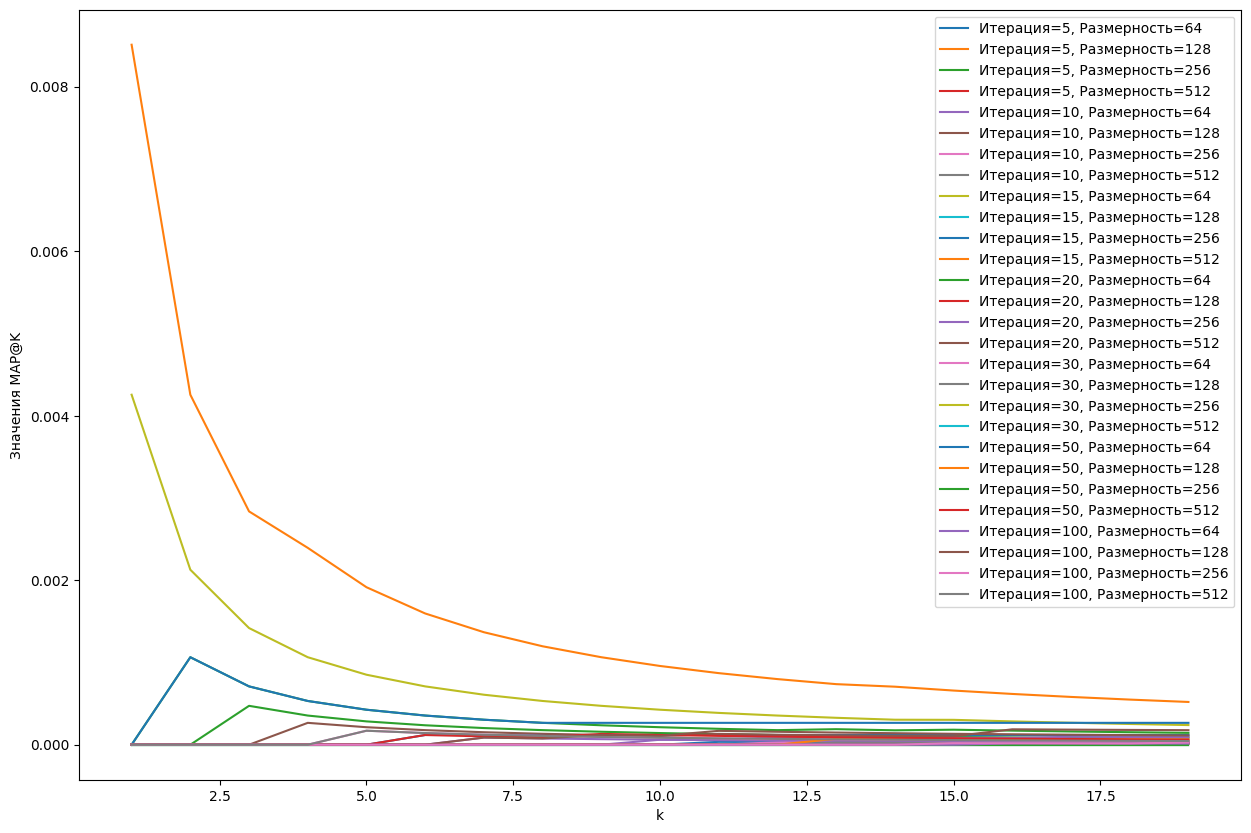

In [ ]:
num_iters = [5, 10, 15, 20, 30, 50, 100]
dims = [64, 128, 256, 512]
kv = range(1, 20)


models_sgd = {iter_num: {dim: None for dim in dims} for iter_num in num_iters}
recs_sgd = {iter_num: {dim: None for dim in dims} for iter_num in num_iters}


for iteration in num_iters:
    for dimen in dims:
        model = HiddenVars(train_ratings, mode='sgd', dim=dimen)
        model.fit(num_iters=iteration)
        recommendations = model.get_test_recommendations(50)

        models_sgd[iteration][dimen] = model
        recs_sgd[iteration][dimen] = recommendations

plt.figure(figsize=(15, 10))


for iteration in num_iters:
    for dimen in dims:
        metrics_sgd = [mapk(test_relevant, recs_sgd[iteration][dimen], k) for k in kv]
        plt.plot(kv, metrics_sgd, label=f'Итерация={iteration}, Размерность={dimen}')

plt.xlabel('k')
plt.ylabel('Значения MAP@K')
plt.legend()
plt.show()

In [ ]:
data_sgd = []

for iteration in num_iters:
    for dimen in dims:
        for k in kv:
            mapk_value = mapk(test_relevant, recs_sgd[iteration][dimen], k)
            data_sgd.append({
                "Iterations": iteration,
                "Dimensions": dimen,
                "k": k,
                "MAP@k": mapk_value
            })


In [ ]:
df_maps_sgd = pd.DataFrame(data_sgd)

In [ ]:
df_maps_sgd.sort_values(by='MAP@k', ascending=False).head(30)

,Iterations,Dimensions,k,MAP@k
209,15,512,1,0.008511
210,15,512,2,0.004255
342,30,256,1,0.004255
211,15,512,3,0.002837
212,15,512,4,0.002394
343,30,256,2,0.002128
213,15,512,5,0.001915
214,15,512,6,0.001596
344,30,256,3,0.001418
215,15,512,7,0.001368


Видим, что при $15$ итерациях, при $d = 512$ и $k = 1$, в $LFM$ выдается самый высокий результат $0.008511$.

----

  0%|          | 0/5 [00:00<?, ?it/s]

129118.86778504927
51798.487232449705
48186.24612868032
47105.885079231804
46651.50796994118


  0%|          | 0/5 [00:00<?, ?it/s]

128906.16377245066
24368.94655985072
21563.59848267081
20662.359536259006
20293.73118115831


  0%|          | 0/5 [00:00<?, ?it/s]

128318.51038013674
1289.3909384324566
1215.7341719971457
1158.6578177710696
1110.8598450088837


  0%|          | 0/5 [00:00<?, ?it/s]

127279.95828927678
1987.874355794933
1863.9445205556253
1759.9974316325374
1670.8942933915557


  0%|          | 0/10 [00:00<?, ?it/s]

129133.08963630717
52177.64704492084
48519.65976718196
47341.788873140125
46814.74820741666
46528.37416216876
46350.477723047145
46229.53470605651
46142.41420467916
46077.102750210295


  0%|          | 0/10 [00:00<?, ?it/s]

128835.67881072596
24372.7802727737
21658.73362208224
20773.70903955169
20394.245583669577
20195.60108429536
20076.065525415277
19997.05198822211
19941.32630626002
19899.980985961844


  0%|          | 0/10 [00:00<?, ?it/s]

128303.62712954826
1299.8077107525914
1227.36018599615
1169.7655061805983
1121.2295019410562
1079.0258333653164
1041.596830229771
1007.9431011037775
977.3726282794869
949.3799754439898


  0%|          | 0/10 [00:00<?, ?it/s]

127238.04555647222
2027.8547749753252
1900.9742686796155
1793.945848660461
1701.9203192159757
1621.593248789555
1550.6172614504408
1487.2684548248455
1430.2458487618856
1378.5450607024254


  0%|          | 0/15 [00:00<?, ?it/s]

129128.91629953716
51891.155838204846
48374.08165741001
47253.346467399664
46742.506292362734
46461.123537543346
46289.108843685426
46176.046704505694
46097.40850886342
46040.308643890756
45997.533734353034
45964.7581600788
45939.19911212197
45918.95540423741
45902.67304303464


  0%|          | 0/15 [00:00<?, ?it/s]

128869.33015314415
24414.69868124789
21689.562078707077
20767.978159245496
20371.947454028512
20170.890244250804
20053.854122530036
19977.879317716935
19924.41371776959
19884.56782725611
19853.611678494497
19828.768651558497
19808.27886863901
19790.97121467153
19776.044798712657


  0%|          | 0/15 [00:00<?, ?it/s]

128357.9463954461
1243.7605094639252
1179.9972758296262
1128.7618882836534
1085.197320002258
1047.0219205619271
1012.933944224179
982.0981750092136
953.9354270090931
928.02155635176
904.0332977440554
881.7166861942789
860.8674159369406
841.3179796019776
822.9288889716711


  0%|          | 0/15 [00:00<?, ?it/s]

127278.25049808902
1995.4996061889299
1874.1316782050756
1771.1467613072712
1682.1937564996572
1604.2677706168108
1535.2115121520985
1473.4270274305616
1417.6998023238311
1367.0866034782582
1320.8412964288343
1278.364239008033
1239.1668284481639
1202.846085830041
1169.0660642614305


  0%|          | 0/20 [00:00<?, ?it/s]

129132.84962749158
52081.95175161322
48470.07646337485
47304.37285388854
46777.29950949243
46496.93025298341
46329.819980306514
46220.031654157574
46142.1223781499
46083.76328830888
46038.4509369491
46002.37533561384
45973.0753914145
45948.850977982846
45928.48564632928
45911.09629063732
45896.0384668625
45882.84045908046
45871.15529674188
45860.72547128199


  0%|          | 0/20 [00:00<?, ?it/s]

128922.98973588126
24190.070862591165
21604.66143879978
20718.487971554263
20321.920010941783
20115.76500605087
19996.212890106133
19921.004545861495
19870.51155877443
19834.644984190818
19807.86549756934
19786.98354540502
19770.083531316326
19755.967997454034
19743.86045302791
19733.241156561486
19723.752915504207
19715.144852045596
19707.237514673925
19699.900479202315


  0%|          | 0/20 [00:00<?, ?it/s]

128325.20870594203
1268.8372853880785
1202.377200233249
1148.4588768602414
1102.4595790579576
1062.1334247970403
1026.1627661251814
993.683102155892
964.0845090345163
936.9144974523861
911.8248961575326
888.5403069437151
866.8381451993765
846.5353664471635
827.4792801158397
809.5409819735177
792.610530825429
776.5933253930853
761.4073300945571
746.9809155594025


  0%|          | 0/20 [00:00<?, ?it/s]

127307.15558342909
1970.2645434021983
1851.846412776701
1751.2802512684848
1664.3442253321134
1588.1235224189124
1520.525728173492
1460.000895956612
1405.3708487448403
1355.720390245097
1310.3253788995532
1268.603673084447
1230.0807721136448
1194.3651875481678
1161.1304282460933
1130.101585392423
1101.0451821640972
1073.7613834717974
1048.07793935665
1023.8454210938529


  0%|          | 0/30 [00:00<?, ?it/s]

129136.95839487508
52209.57551494426
48502.35686005268
47278.04028834386
46738.01887724674
46456.257242014195
46291.74940527056
46186.73323177171
46114.51865648205
46061.768503708154
46021.35034245073
45989.199950889124
45962.86726749045
45940.804724546295
45921.99739021211
45905.75810115228
45891.60680296642
45879.19588542097
45868.26268985219
45858.599284463104
45850.03370232484
45842.418796527825
45835.62596190692
45829.54174667173
45824.06600507106
45819.11074860459
45814.59923015488
45810.46504702835
45806.65119690473
45803.10909455679


  0%|          | 0/30 [00:00<?, ?it/s]

128826.65878112361
24462.063591649043
21712.457813750872
20794.395973263625
20398.09159252594
20194.377184467878
20075.270630535477
19998.340982351878
19944.735057911457
19905.1350910158
19874.489420122543
19849.852220368637
19829.411359230366
19812.007109058497
19796.873110628614
19783.48802385037
19771.486979177193
19760.607275526145
19750.654431342195
19741.480610858034
19732.970688755013
19725.03308548546
19717.593616390634
19710.591269169505
19703.975233890338
19697.702761146073
19691.737579009696
19686.048695602283
19680.609474127505
19675.396905069614


  0%|          | 0/30 [00:00<?, ?it/s]

128311.21639030903
1271.835718427916
1207.9262906642816
1155.146858389608
1109.7326420148756
1069.7214212864394
1033.9146713969365
1001.5063891588312
971.9188007946173
944.7186526106534
919.5700606468054
896.2058853534814
874.4093175714218
854.0014784354834
834.8327547713386
816.7765582834646
799.7247154255206
783.5839883492704
768.2734010298692
753.7221514980838
739.8679590529289
726.6557398226272
714.0365339143754
701.9666279040531
690.4068308302319
679.3218721000164
668.679897146453
658.4520421943724
648.612073532359
639.1360797926094


  0%|          | 0/30 [00:00<?, ?it/s]

127265.14149538886
2005.3480271766969
1881.7534684268549
1777.2396269078386
1687.1976623010744
1608.4725688158567
1538.8150350481817
1476.5683123610227
1420.4790099297616
1369.5774342695313
1323.098990476796
1280.4308780305041
1241.0749371194725
1204.6211310743706
1170.7282232603777
1139.1094360214781
1109.5216328285871
1081.7570380016184
1055.6368150479702
1031.0060270432753
1007.729638418043
985.6893115987705
964.7808171903371
944.9119224829914
926.000656803961
907.9738761595441
890.7660676908243
874.3183476512947
858.5776167826937
843.495844492704


  0%|          | 0/50 [00:00<?, ?it/s]

129143.4303598091
51956.9708667759
48404.85465077881
47226.81650283049
46692.561655947735
46405.67250407169
46233.821857012954
46122.68638676397
46046.539141569425
45991.959721046514
45951.45358984776
45920.57450161201
45896.52613069446
45877.456516954626
45862.08828065165
45849.51420769759
45839.07671957108
45830.29215892239
45822.80070136121
45816.331978321694
45810.68091281283
45805.6904789127
45801.23928322948
45797.232558840646
45793.59559673
45790.26892811384
45787.20476946306
45784.36438140946
45781.716091678514
45779.23380274925
45776.89585533155
45774.684154756425
45772.5834930772
45770.58101807097
45768.665813471096
45766.82856421373
45765.06128726276
45763.35711350399
45761.71010976846
45760.11513266994
45758.56770786796
45757.06392981321
45755.600378106814
45754.1740474235
45752.78228857494
45751.42275877076
45750.093379509606
45748.792300828114
45747.51787086441
45746.26860988712


  0%|          | 0/50 [00:00<?, ?it/s]

128829.74585339108
24564.278831170424
21778.282577153477
20843.629720063993
20432.586842703393
20218.172135230954
20092.177087085678
20011.234715951865
19955.405831626813
19914.50712298164
19882.954897601892
19857.537695856667
19836.336819454096
19818.163941243587
19802.255533600794
19788.102171671708
19775.35104072227
19763.74904435996
19753.108783440686
19743.28759669843
19734.174192739134
19725.67981298647
19717.732203052252
19710.271404721516
19703.246779434394
19696.614890683944
19690.33799409526
19684.382957062106
19678.72047851261
19673.324514777323
19668.17184450373
19663.241726206426
19658.515617476376
19653.976935993574
19649.610850131383
19645.40409194045
19641.344788381197
19637.422308454075
19633.627124810064
19629.95068885829
19626.38531854477
19622.924097991363
19619.560788159844
19616.289747666102
19613.105862853474
19610.004486236136
19606.981382448754
19604.03268088005
19601.15483422481
19598.344582247166


  0%|          | 0/50 [00:00<?, ?it/s]

128370.77765540479
1236.1376491793833
1172.6901375994726
1121.536559956445
1078.0396957614114
1039.9482531560477
1005.9604821439988
975.2367467894073
947.1937816624112
921.4043657543237
897.5430266296563
875.3542332979201
854.6325671986721
835.209726775566
816.9456554614849
799.7222760510998
783.4389383522102
768.009031019796
753.3574074267351
739.4183948923044
726.1342310656329
713.4538190196404
701.3317241425252
689.7273571766261
678.604302479468
667.9297609315925
657.6740842902939
647.8103832277613
638.3141952370817
629.1632015909304
620.3369847750997
611.8168195528657
603.5854921506082
595.6271430858567
587.9271299960077
580.4719074462085
573.2489212511808
566.2465152325885
559.4538486888149
552.8608231249747
546.4580170180473
540.2366275753575
534.1884186097727
528.3056737671949
522.5811544594126
517.0080619541664
511.58000312070214
506.2909594357183
501.1352588681236
496.1075503387528


  0%|          | 0/50 [00:00<?, ?it/s]

127316.50874130368
1963.964963855077
1847.5918356530892
1748.4543631324
1662.538635332886
1587.0587750139503
1520.0056370798304
1459.8848288573245
1405.5562396676698
1356.131347337858
1310.905060653179
1269.3090686899532
1230.8790559226575
1195.2311286680576
1162.0445214058207
1131.0486837570593
1102.013485264784
1074.7416795382796
1049.0630327227627
1024.8296954780958
1001.9125167770875
980.1980797047834
959.5862966765026
939.9884426349545
921.3255344961509
903.5269864686446
886.5294871417871
870.2760561155152
854.7152469766596
839.8004704185198
825.4894164449054
811.7435590430927
798.5277295256792
785.8097475797996
773.560101010949
761.7516666049605
750.3594661410291
739.3604522796237
728.7333201450767
718.4583410114159
708.5172150697204
698.8929407257623
689.5696982806597
680.5327461496394
671.7683280509256
663.2635898053803
655.0065045927942
646.985805656769
639.1909256105761
631.6119415818209


  0%|          | 0/100 [00:00<?, ?it/s]

129136.31781525341
52314.66571303818
48485.656653348015
47250.99562852926
46725.97096441416
46454.74455704107
46294.28893611624
46189.206727591074
46114.57253645012
46058.08301581331
46013.28047920883
45976.617824822904
45946.05942471881
45920.36184803957
45898.68926543129
45880.41140230188
45865.00588668754
45852.01786039294
45841.04703237981
45831.744793183716
45823.81291832127
45817.000862365916
45811.101349488665
45805.94492393536
45801.394221213566
45797.338512452385
45793.68882861247
45790.37378270921
45787.33609045651
45784.529727904264
45781.91763942994
45779.46990534883
45777.16228497079
45774.97506191378
45772.89213043433
45770.90027276664
45768.988587267544
45767.14803538751
45765.37108218874
45763.651410518665
45761.983693212496
45760.36341107946
45758.78670706023
45757.25026902028
45755.75123526266
45754.28711810225
45752.855741841704
45751.455192255344
45750.08377529576
45748.73998321329
45747.422466652024
45746.13001157465
45744.86152010943
45743.61599458346
45742.392524

  0%|          | 0/100 [00:00<?, ?it/s]

128873.06115863401
24229.081988060298
21577.48530968644
20702.893450616044
20320.81521907311
20126.046150178307
20015.329415999164
19946.160917859146
19899.16052348696
19864.854992862754
19838.31871445284
19816.83803041407
19798.835763006682
19783.348801484663
19769.76100641235
19757.660215188618
19746.758602767142
19736.846835966713
19727.766934185882
19719.395796692304
19711.63495133641
19704.403995283014
19697.636259357267
19691.275833009477
19685.275439115314
19679.594854669012
19674.199695115865
19669.06045149479
19664.151711354712
19659.45151888563
19654.940844153392
19650.603140030573
19646.42397084687
19642.39070033754
19638.49222894221
19634.718772325472
19631.061674396613
19627.513249233805
19624.066647242864
19620.715741645927
19617.455032038724
19614.27956228923
19611.184850501628
19608.166829142276
19605.221793740377
19602.3463588336
19599.537420049885
19596.7921213945
19594.107826963504
19591.48209642868
19588.912663743526
19586.39741860656
19583.93439029012
19581.5217335

  0%|          | 0/100 [00:00<?, ?it/s]

128318.22582485671
1271.8614603115689
1207.8672361923495
1154.7777272055316
1109.0740919011373
1068.83566541326
1032.8622219840847
1000.337171785498
970.6718253299234
943.4237101323823
918.2496415731558
894.8768428853884
873.0841965243235
852.689542856461
833.5407721872923
815.5093954764396
798.485790879402
782.3756164396757
767.0970545858835
752.5786627073614
738.7576736842718
725.578635966057
712.9923136168167
700.9547880619574
689.4267181004009
678.3727254711742
667.7608809581607
657.5622717108926
647.7506347180494
638.3020445516477
629.1946459428513
620.4084236293676
611.9250033709405
603.727479180421
595.8002627009208
588.1289514094688
580.7002128679122
573.50168273453
566.5218746091324
559.7501000994833
553.1763977511816
546.7914696791718
540.5866249237663
534.5537286943332
528.68515677742
522.9737544923213
517.4127996670576
511.995969161345
506.7173085467522
501.5712045879237
496.5523602240326
491.6557717818516
486.87670818542176
482.2106919643764
477.6534818618487
473.201056900

  0%|          | 0/100 [00:00<?, ?it/s]

127355.26963048273
1934.1627207374684
1824.3810061688646
1730.1112518713007
1647.8926500897683
1575.284320790959
1510.5025161587625
1452.2057014224772
1399.3606678447138
1351.1556124236874
1306.9417290105885
1266.19279382466
1228.4764896798476
1193.4336098616395
1160.7626848385758
1130.208423101144
1101.5528878258233
1074.6086697827477
1049.2135399012607
1025.2262141654899
1002.5229653776233
980.9948872671536
960.5456665653226
941.0897544311367
922.5508547479268
904.8606660287743
887.9578277224361
871.7870326488817
856.2982752396878
841.4462115466026
827.1896118399684
813.4908901714826
800.3156985165984
787.6325750854799
775.412638485238
763.6293207885502
752.2581337470422
741.2764633732685
730.6633889402616
720.3995229397509
710.4668692377463
700.8486970232422
691.5294284772727
682.4945384295835
673.730464538895
665.2245266867556
656.9648544877276
648.940321966433
641.1404886062203
633.5555459763851
626.1762694029773
618.9939740650474
612.0004750732928
605.1880511131254
598.5494112665

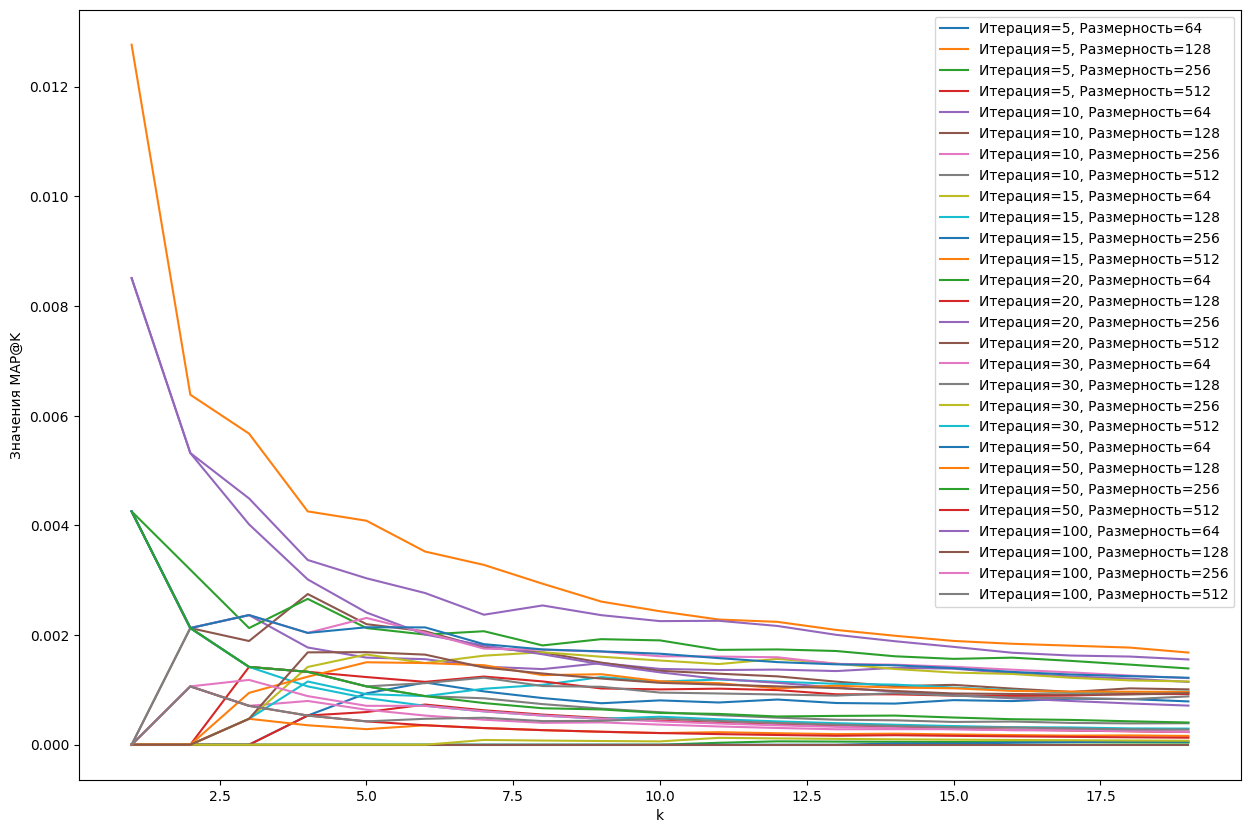

In [ ]:
#Сделаем аналогично для ALS


num_iters = [5, 10, 15, 20, 30, 50, 100]
dims = [64, 128, 256, 512]
kv = range(1, 20)


models_als = {iter_num: {dim: None for dim in dims} for iter_num in num_iters}
recs_als = {iter_num: {dim: None for dim in dims} for iter_num in num_iters}


for iteration in num_iters:
    for dimen in dims:
        model = HiddenVars(train_ratings, mode='als', dim=dimen)
        model.fit(num_iters=iteration)
        recommendations = model.get_test_recommendations(50)

        models_als[iteration][dimen] = model
        recs_als[iteration][dimen] = recommendations

plt.figure(figsize=(15, 10))


for iteration in num_iters:
    for dimen in dims:
        metrics_als = [mapk(test_relevant, recs_als[iteration][dimen], k) for k in kv]
        plt.plot(kv, metrics_als, label=f'Итерация={iteration}, Размерность={dimen}')

plt.xlabel('k')
plt.ylabel('Значения MAP@K')
plt.legend()
plt.show()

In [ ]:
data_als = []

for iteration in num_iters:
    for dimen in dims:
        for k in kv:
            mapk_value = mapk(test_relevant, recs_als[iteration][dimen], k)
            data_als.append({
                "Iterations": iteration,
                "Dimensions": dimen,
                "k": k,
                "MAP@k": mapk_value
            })


In [ ]:
df_maps_als = pd.DataFrame(data_als)
df_maps_als.sort_values(by='MAP@k', ascending=False).head(30)

,Iterations,Dimensions,k,MAP@k
19,5,128,1,0.012766
266,20,256,1,0.008511
456,100,64,1,0.008511
20,5,128,2,0.006383
21,5,128,3,0.005674
267,20,256,2,0.005319
457,100,64,2,0.005319
458,100,64,3,0.004492
22,5,128,4,0.004255
304,30,64,1,0.004255


Видим, что при $5$ итерациях, при $d = 128$ и $k = 1$, в $ALS$ выдается самый высокий результат $0.012766$.

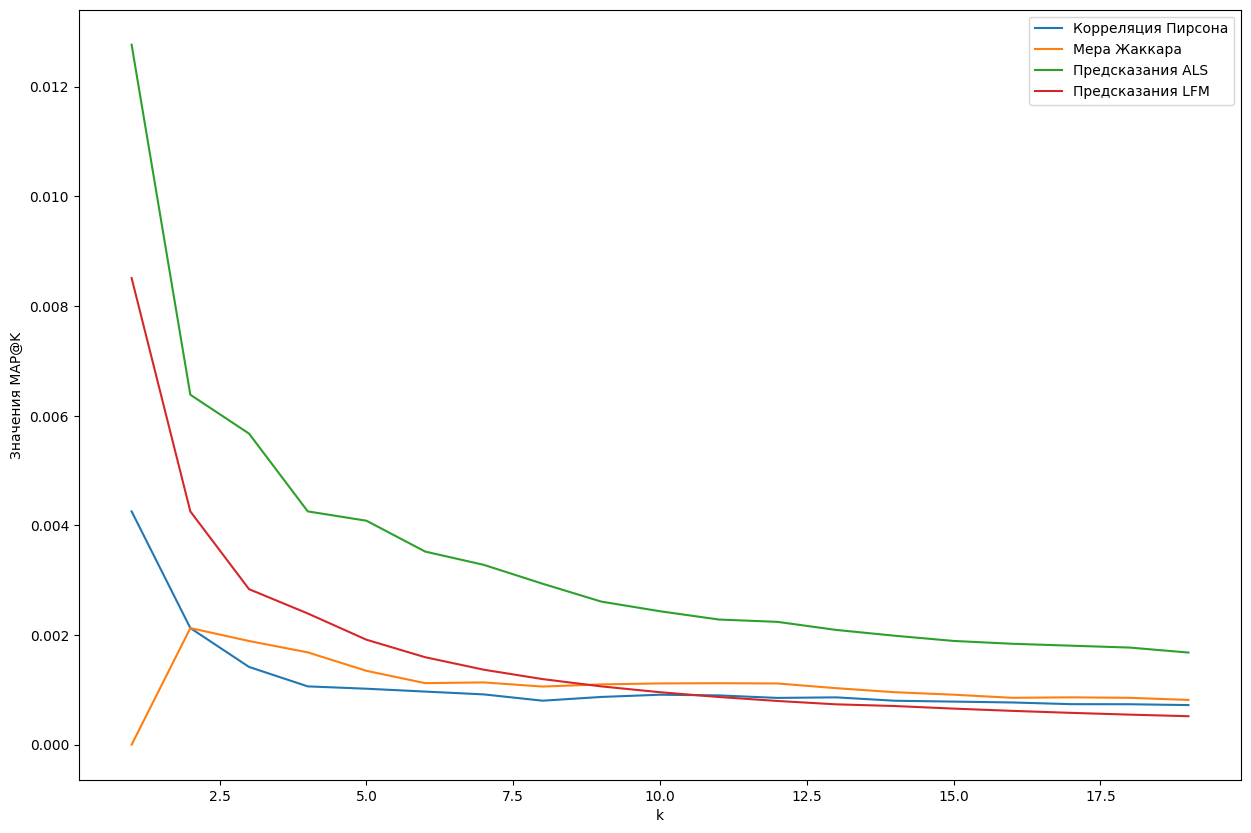

In [ ]:
kv = range(1, 20)

pears = User2User(train_ratings, similarity_func=pearson)
jacc = User2User(train_ratings, similarity_func=jaccard)


recs_pears = pears.get_test_recommendations(50)
recs_jacc = jacc.get_test_recommendations(50)


plt.figure(figsize=(15, 10))

metrics_pears = [mapk(test_relevant, recs_pears, k) for k in kv]
metrics_jacc = [mapk(test_relevant, recs_jacc, k) for k in kv]
metrics_als = [mapk(test_relevant, recs_als[5][128], k) for k in kv]
metrics_sgd = [mapk(test_relevant, recs_sgd[15][512], k) for k in kv]


plt.plot(kv, metrics_pears, label='Корреляция Пирсона')
plt.plot(kv, metrics_jacc, label='Мера Жаккара')
plt.plot(kv, metrics_als, label='Предсказания ALS')
plt.plot(kv, metrics_sgd, label='Предсказания LFM')
plt.xlabel('k')
plt.ylabel('Значения MAP@K')
plt.legend()
plt.show()

**Видим что ALS просто разносит все остальные, потом уже идет LFM и после них идут коллаборативные фильтрации. Особенно это видно на k = 1 и до k = 5**

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [ ]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = models_als[5][128].Q @ models_als[5][128].Q[example_trackId]
preds = preds / np.sqrt((models_als[5][128].Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [ ]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(models_als[5][128].Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2058,Последний герой,['КИНО'],0.765838
2179,Восьмиклассница,['КИНО'],0.720959
5153,Stormbringer,['Deep Purple'],0.699919
9689,Bicycle Race,['Queen'],0.699919
16637,Zodiac,['Zodiac'],0.699919
5570,Моё сердце,['Сплин'],0.697345
9449,Это всё…,['ДДТ'],0.683584
16224,Пока горит свеча,['Машина времени'],0.678933
5517,Варвара,['Би-2'],0.676142
